# Параметр Тумре

In [59]:
import os
%pylab
%matplotlib inline
%run ./load_notebook.py

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


/home/lera/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [60]:
import numpy as np
import scipy.interpolate as inter

In [61]:
import functions

In [62]:
Distance = 10.57 # Mpc
incl = 62.
cosi = np.cos(incl / 180. * np.pi)
sini = np.sin(incl / 180. * np.pi)

In [63]:
sigma_s = np.load('sigma_s.npy')
Sigma_H2 = np.load('Sigma_H2.npy')
sigma_HI = np.load('sigma_HI.npy')
Sigma_HI = np.load('Sigma_HI.npy')
Sigma_s = np.load('Sigma_s.npy')
sig_R_max = np.load('sig_R_max.npy')
sig_R_min = np.load('sig_R_min.npy')
r_HI = np.load('r_HI.npy')
vel_HI = np.load('vel_HI.npy')
kappa = np.load('kappa.npy')
dist_kpc = np.load('dist_kpc.npy')

In [64]:
velocity_approx = poly1d(polyfit(r_HI, vel_HI, deg=4))

In [65]:
dR =(Distance*1000*2*np.pi)/(360*60*60.)
G = 4.32
Qeff_max = np.zeros(dist_kpc.shape)
Qeff_min = np.zeros(dist_kpc.shape)
bark = np.zeros(dist_kpc.shape)
bark_max = np.zeros(dist_kpc.shape)
Qg = np.zeros(dist_kpc.shape)
Qs_min = np.zeros(dist_kpc.shape)
Qs_max = np.zeros(dist_kpc.shape)
Sigma_g = np.zeros(dist_kpc.shape)

step = 0
errors = 0
for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        step+=1
        if step % 1000 == 0:
            print(step)
        c = sigma_HI[i][j]/1000.
        Sigma_g[i][j] = 1.36*(Sigma_HI[i][j] + Sigma_H2[i][j])
        kappa = functions.epic_freq(velocity_approx, dist_kpc[i][j], dR)
        Sigma_s_ = Sigma_s[i][j]
        s_R_max = sig_R_max[i][j]
        s_R_min = sig_R_min[i][j]
        Qg[i][j] = kappa * c / (math.pi * G * Sigma_g[i][j])
        Qs_max[i][j] = kappa * s_R_max / (3.36 * G * Sigma_s_)
        Qs_min[i][j] = kappa * s_R_min / (3.36 * G * Sigma_s_)
        
       
        try:
            root_for_max, qeff = functions.FindMaxQeffKinem(rangek=np.arange(0.01, 50., 1.), Qs=Qs_min[i][j], Qg=Qg[i][j], s=c/s_R_min)
        except ValueError:
            errors+=1
            qeff = 0.01
            root_for_max = -1.
        Qeff_min[i][j] = 1./qeff
        bark[i][j] = root_for_max
        
        try:
            root_for_max, qeff = functions.FindMaxQeffKinem(rangek=np.arange(0.01, 50., 1.), Qs=Qs_max[i][j], Qg=Qg[i][j], s=c/s_R_min)
        except ValueError:
            errors+=1
            qeff = 0.01
            root_for_max = -1.
        Qeff_max[i][j] = 1./qeff
        bark_max[i][j] = root_for_max
        
print('Errors:{}'.format(errors))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Errors:4704


In [66]:
np.save('Qg.npy', Qg)
np.save('Qs_min.npy', Qs_min)
np.save('Qs_max.npy', Qs_max)
np.save('Qeff_min.npy', Qeff_min)
np.save('Qeff_max.npy', Qeff_max)
np.save('bark.npy',bark)
np.save('bark_max.npy',bark_max)

Text(0.5, 1.0, '$H_{\\alpha}$')

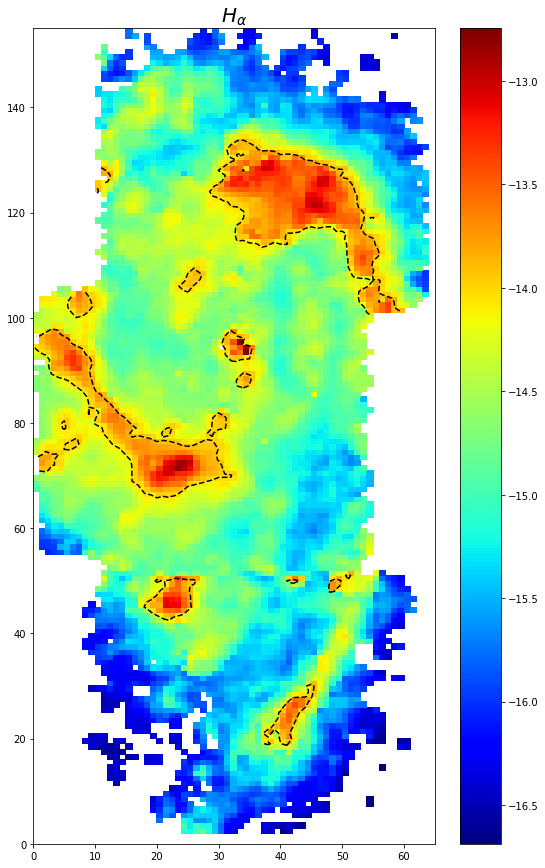

In [67]:
H_alpha = np.load('H_alpha.npy')
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
fig = plt.figure(figsize=[9,15])
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.,-12], aspect='auto', alpha=1, colors='black')
quadmesh = plt.pcolormesh(X, Y, np.log10(H_alpha), cmap='jet')
plt.colorbar()
plt.title(r'$H_{\alpha}$', fontsize=20)

In [68]:
Qg = np.load('Qg.npy')
Qs_min = np.load('Qs_min.npy')
Qeff_min = np.load('Qeff_min.npy')
Qs_max = np.load('Qs_max.npy')
Qeff_max = np.load('Qeff_max.npy')
bark = np.load('bark.npy')
bark_max = np.load('bark_max.npy')

Text(0.5, 1.0, '$\\bar{k}$')

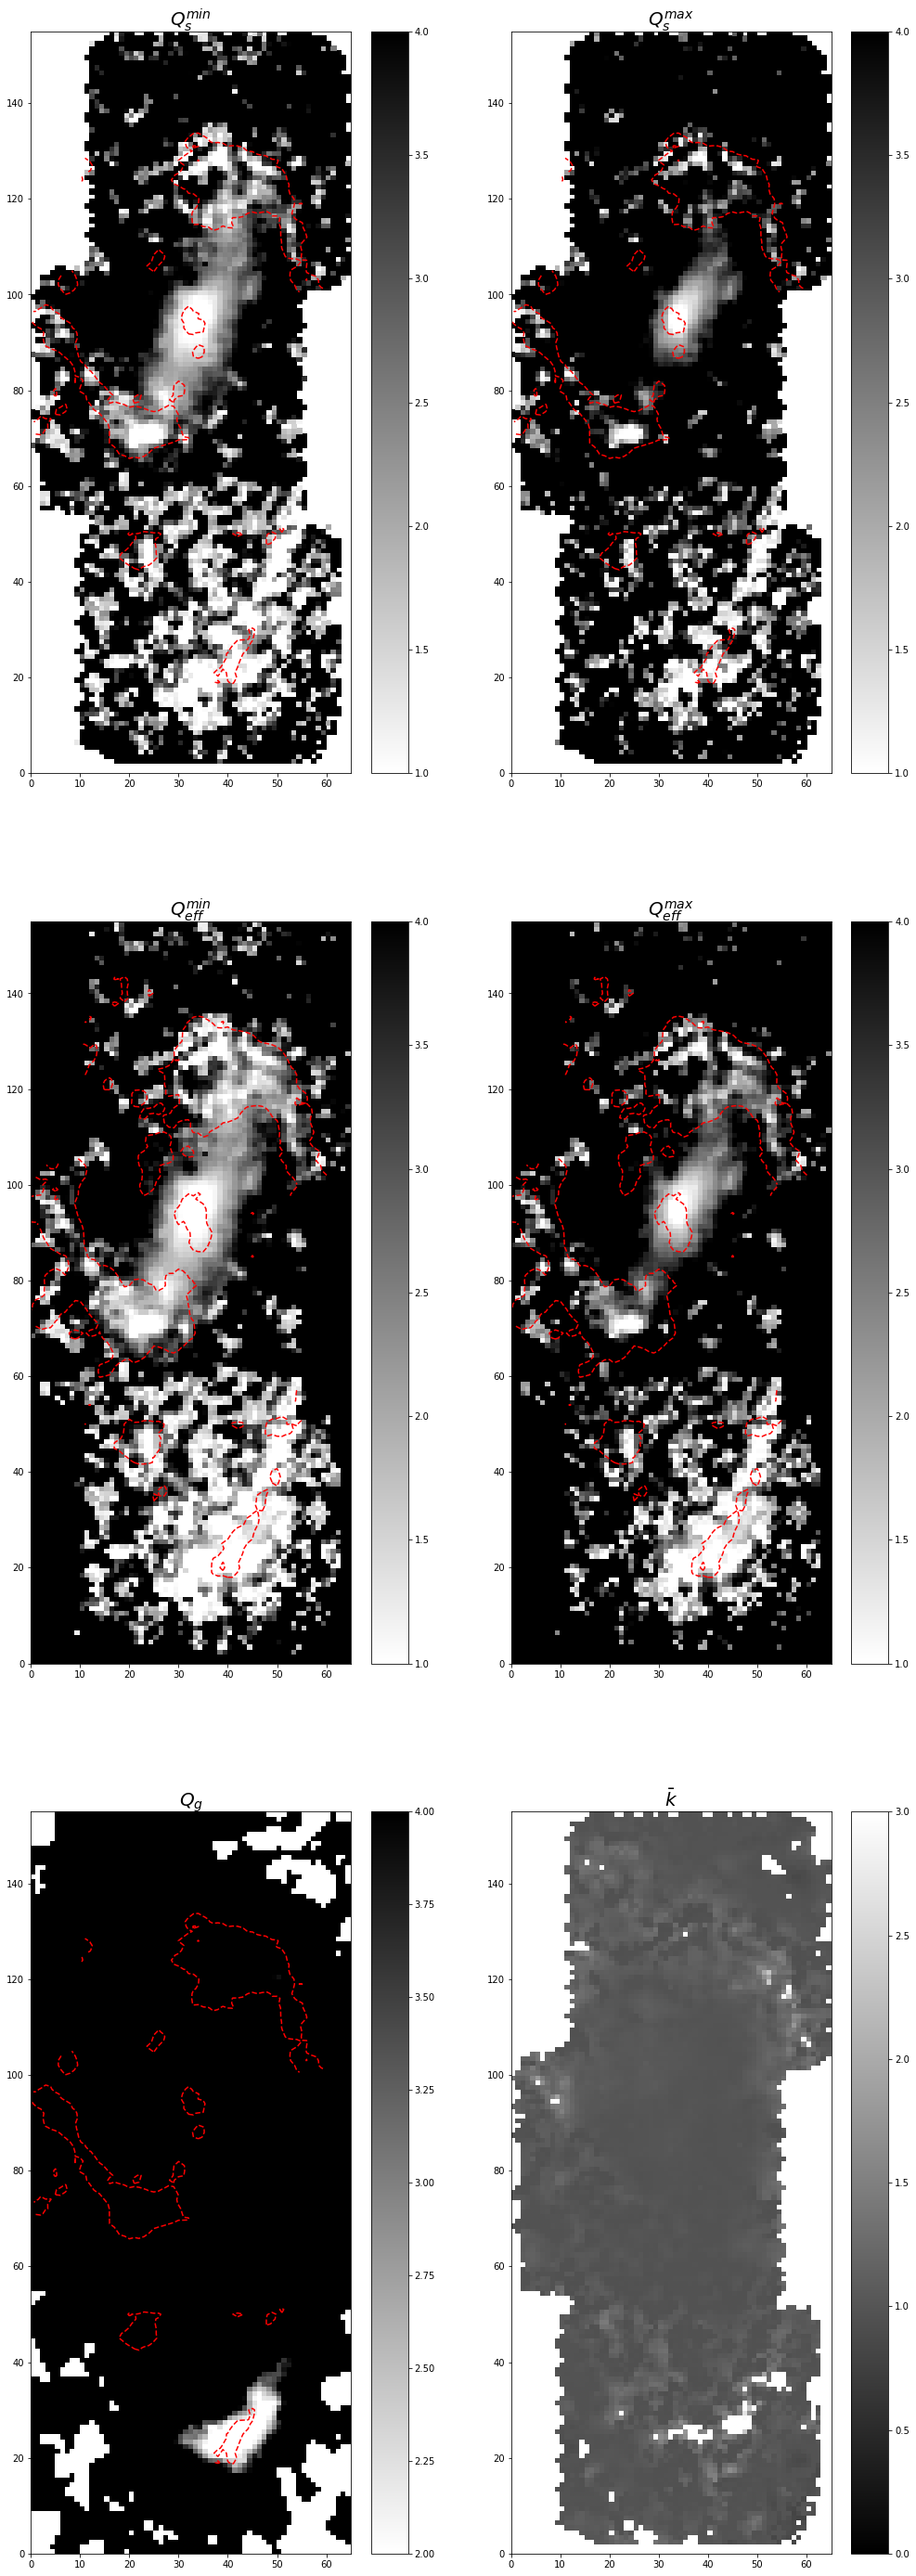

In [69]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[17, 50])
plt.subplot(3,2,1)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qs_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=1., vmax=4.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{s}^{min}$', fontsize=20)

plt.subplot(3,2,2)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qs_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=1., vmax=4.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{s}^{max}$', fontsize=20)

plt.subplot(3,2,3)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.3,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=1., vmax=4.)
plt.colorbar()
plt.title(r'$Q_{eff}^{min}$', fontsize=20)

plt.subplot(3,2,4)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.3,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=1., vmax=4.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{eff}^{max}$', fontsize=20)

plt.subplot(3,2,5)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qg, cmap='gist_yarg')
quadmesh.set_clim(vmin=2., vmax=4.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{g}$', fontsize=20)

plt.subplot(3,2,6)
quadmesh = plt.pcolormesh(X, Y, bark, cmap='gray')
quadmesh.set_clim(vmin=0., vmax=3.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$\bar{k}$', fontsize=20)

Text(0.5, 1.0, '$Q_{eff}^{max}$')

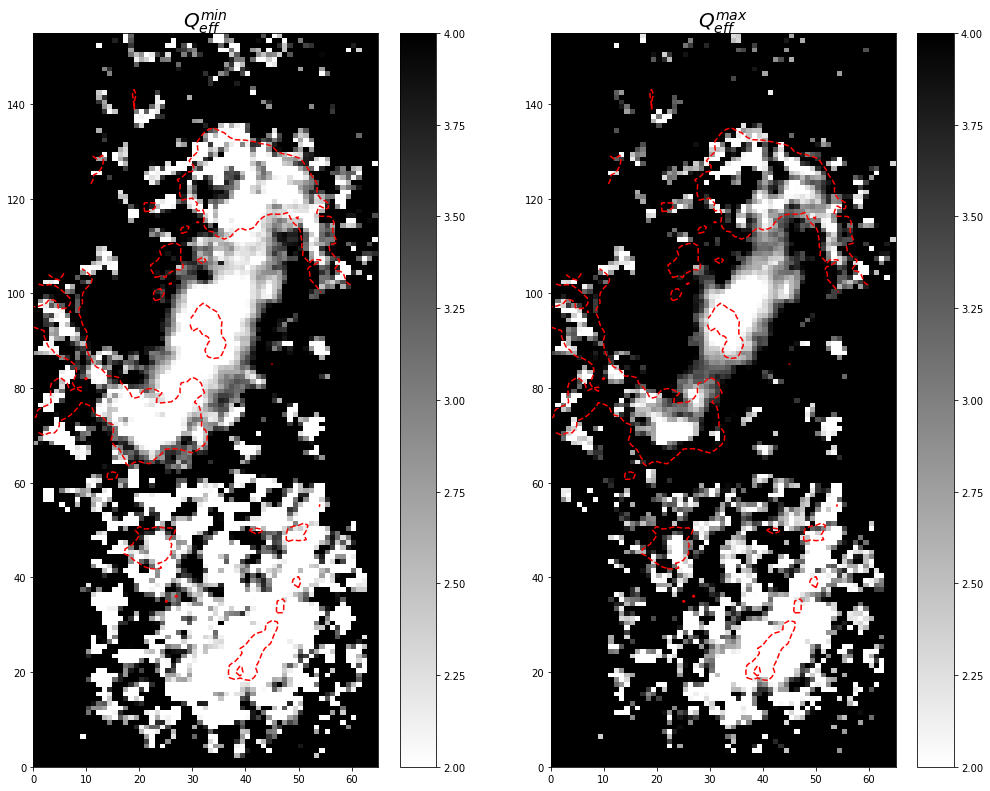

In [70]:

X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[17, 13.5])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.2,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=2., vmax=4.)
plt.colorbar()
plt.title(r'$Q_{eff}^{min}$', fontsize=20)

plt.subplot(1,2,2)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.2,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=2., vmax=4.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{eff}^{max}$', fontsize=20)


Text(0.5, 1.0, '$Q_{eff}^{max}$')

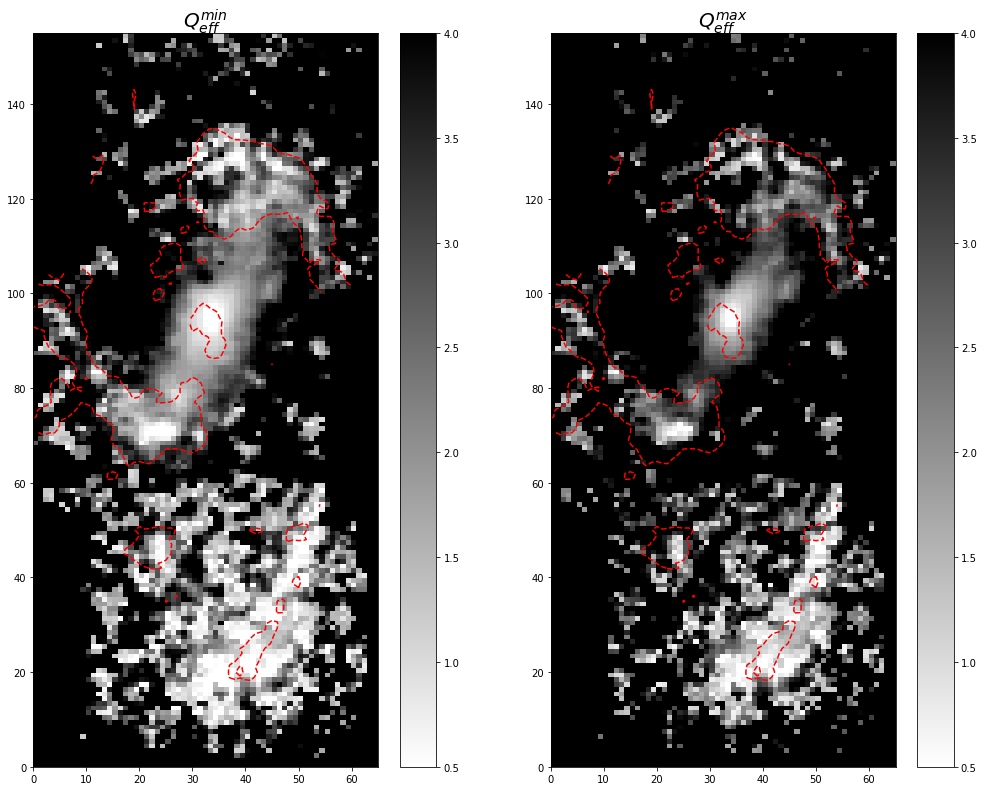

In [71]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[17, 13.5])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.2,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=0.5, vmax=4.)
plt.colorbar()
plt.title(r'$Q_{eff}^{min}$', fontsize=20)

plt.subplot(1,2,2)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.2,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=0.5, vmax=4.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{eff}^{max}$', fontsize=20)


Text(0.5, 1.0, '$Q_{eff}^{max}$')

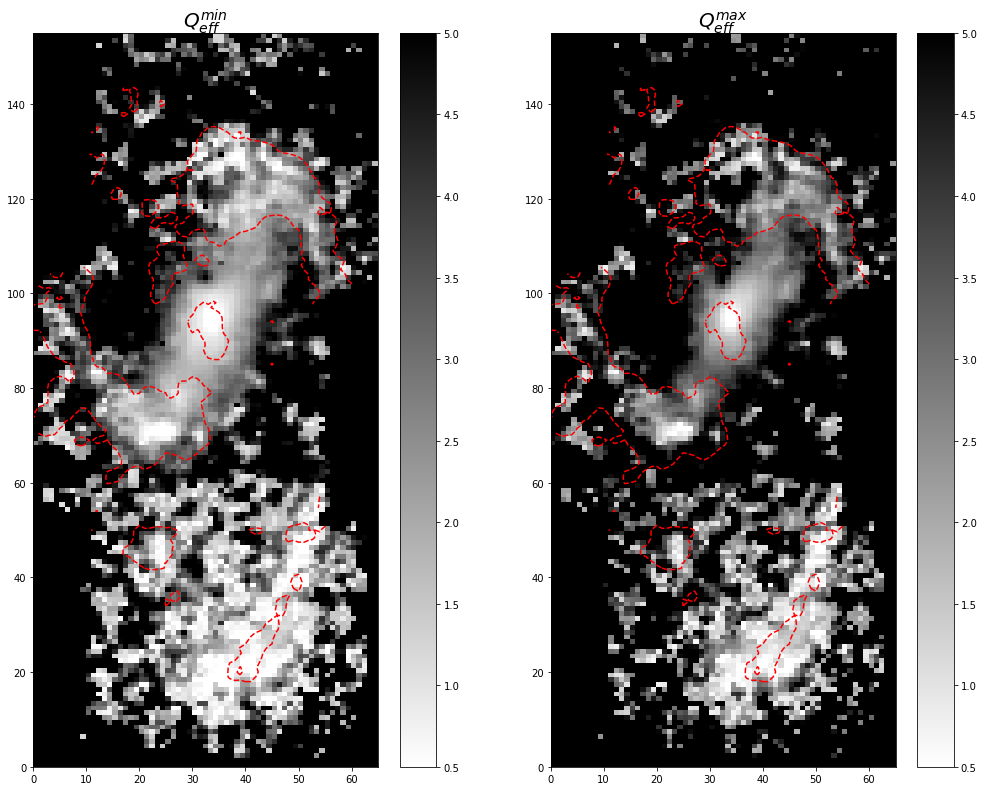

In [72]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[17, 13.5])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.3,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=0.5, vmax=5.)
plt.colorbar()
plt.title(r'$Q_{eff}^{min}$', fontsize=20)

plt.subplot(1,2,2)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.3,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=0.5, vmax=5.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{eff}^{max}$', fontsize=20)


Text(0.5, 1.0, '$Q_{eff}^{max}$')

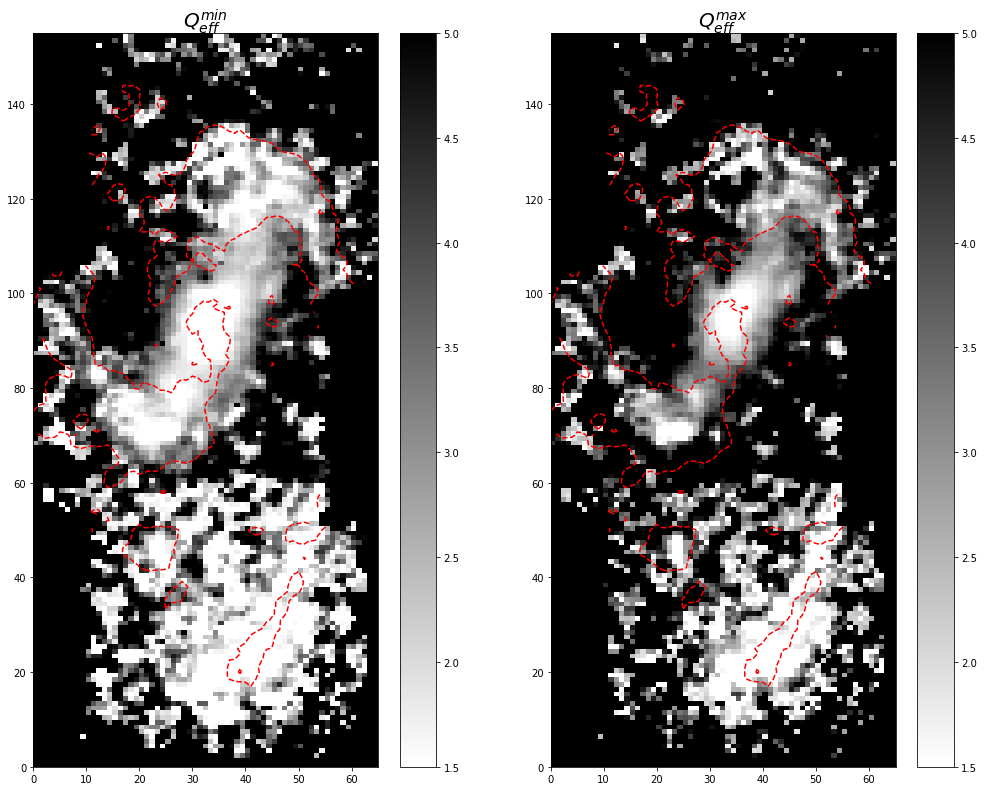

In [73]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[17, 13.5])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.4,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=1.5, vmax=5.)
plt.colorbar()
plt.title(r'$Q_{eff}^{min}$', fontsize=20)

plt.subplot(1,2,2)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.4,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=1.5, vmax=5.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{eff}^{max}$', fontsize=20)


Text(0.5, 1.0, '$Q_{eff}^{max}$')

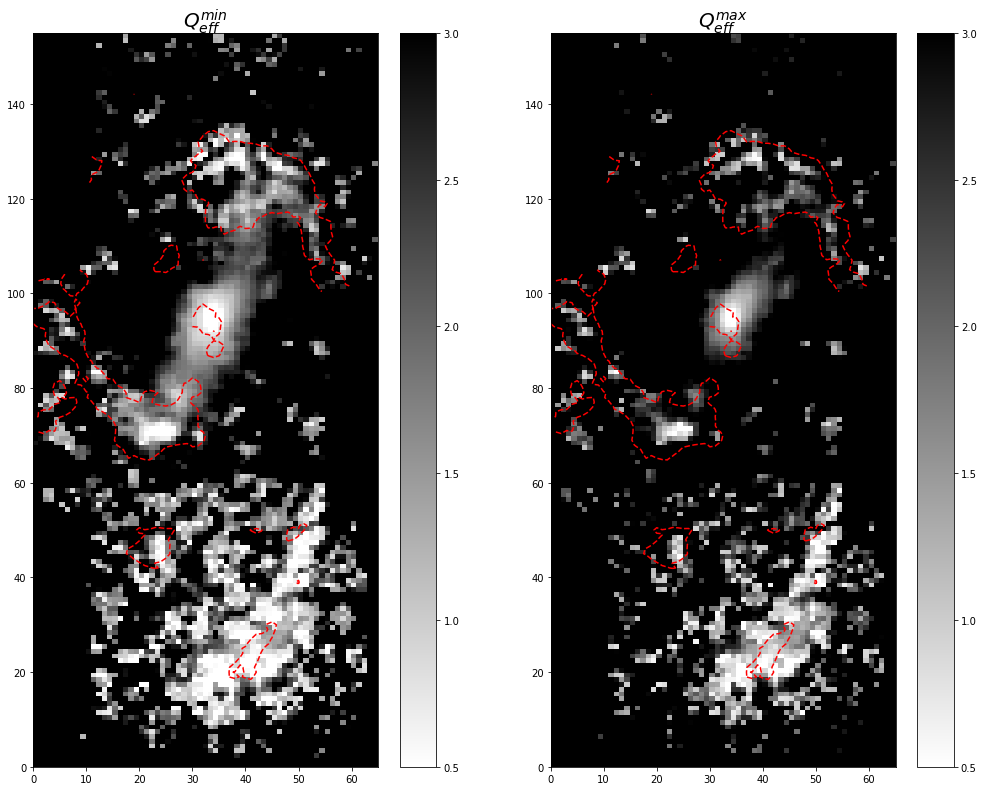

In [74]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[17, 13.5])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.1,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=0.5, vmax=3.)
plt.colorbar()
plt.title(r'$Q_{eff}^{min}$', fontsize=20)

plt.subplot(1,2,2)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.1,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=0.5, vmax=3.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{eff}^{max}$', fontsize=20)


Text(0.5, 1.0, '$Q_{eff}^{max}$')

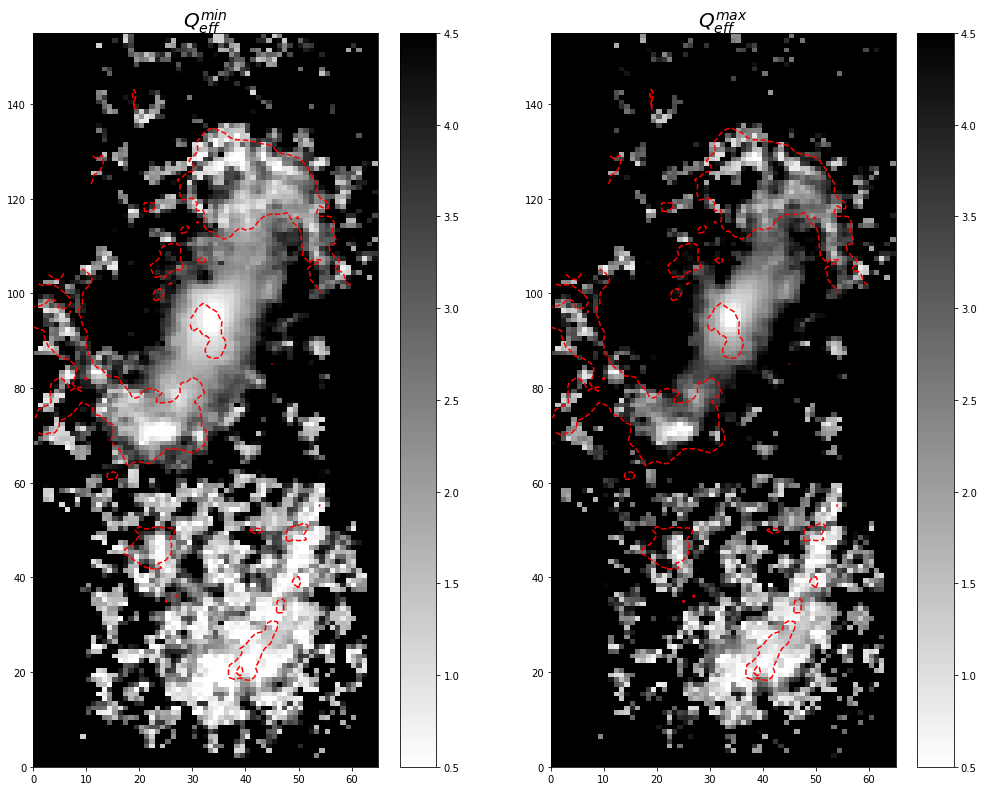

In [75]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[17, 13.5])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.2,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=0.5, vmax=4.5)
plt.colorbar()
plt.title(r'$Q_{eff}^{min}$', fontsize=20)

plt.subplot(1,2,2)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.2,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=0.5, vmax=4.5)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{eff}^{max}$', fontsize=20)